## Multivariate LSTM Forecast model for multiple outputs

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   
5        0.0        0.0        0.0        0.0        0.0        0.0   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var32(t-1)  var33(t-1)  \
1        0.0        0.0        0.0         0.0  ...         0.0         0.0   
2        0.0        0.0        0.0         0.0  ...         0.0         0.0   
3        0.0        0.0        0.0         0.0  ...         0.0         0.0   
4        0.0        0.0        0.0         0.0  ...         0.0         0.0   
5        0.0        0.0        1.0         1.0  ...         0.0         0.0   

   var34(t-1)  var35(t-1)  var36(t-1)  var37(t-1)  var38(t-1)  var39(t-1)  \
1         0.0        

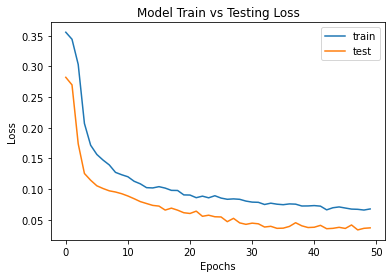

Test RMSE: 98.807
Test MAE: 72.996


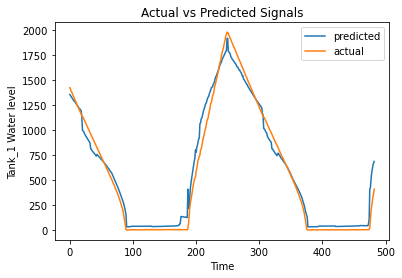

In [4]:
from math import sqrt
from numpy import array
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dropout
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


# load dataset
dataset = read_csv('phy_att_test_processed.csv', header=0, index_col=0)
values = dataset.to_numpy()
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[0,1,2,3,4,5]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39]], axis=1, inplace=True)
reframed.drop(reframed.columns[[41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
values = reframed.values
#n_train_hours = 365 * 24
#n_train_hours = 484
n_train_hours = 1936
# Not 1936
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
#model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(20, activation='relu',return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(10, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(5, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
#model.compile(loss='mae', optimizer='adam')
model.compile(loss='mae', optimizer='adam')
# fit network
#history = model.fit(train_X, train_y, epochs=70, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
history = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.title('Model Train vs Testing Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

'''
pyplot.plot(inv_yhat, label='predicted')
pyplot.plot(test_y, label='actual')
pyplot.legend()
pyplot.show()
'''

# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
mae = mean_absolute_error(inv_y, inv_yhat)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

# # Save the model to disk
# model.save('lstm_model.h5')
# print('Model saved to disk')

pyplot.xlabel('Time')
pyplot.ylabel('Tank_1 Water level')
pyplot.title('Actual vs Predicted Signals')
pyplot.plot(inv_yhat, label='predicted')
pyplot.plot(inv_y, label='actual')
pyplot.legend()
# pyplot.legend(['train','test'], loc='upper left')
pyplot.show()


Epoch 1/200
27/27 - 24s - loss: 0.2236 - val_loss: 0.1697 - 24s/epoch - 875ms/step
Epoch 2/200
27/27 - 1s - loss: 0.1799 - val_loss: 0.1348 - 606ms/epoch - 22ms/step
Epoch 3/200
27/27 - 0s - loss: 0.1208 - val_loss: 0.1034 - 331ms/epoch - 12ms/step
Epoch 4/200
27/27 - 0s - loss: 0.0914 - val_loss: 0.0886 - 497ms/epoch - 18ms/step
Epoch 5/200
27/27 - 0s - loss: 0.0673 - val_loss: 0.0612 - 254ms/epoch - 9ms/step
Epoch 6/200
27/27 - 0s - loss: 0.0494 - val_loss: 0.0473 - 255ms/epoch - 9ms/step
Epoch 7/200
27/27 - 0s - loss: 0.0443 - val_loss: 0.0432 - 271ms/epoch - 10ms/step
Epoch 8/200
27/27 - 0s - loss: 0.0396 - val_loss: 0.0371 - 242ms/epoch - 9ms/step
Epoch 9/200
27/27 - 0s - loss: 0.0343 - val_loss: 0.0304 - 242ms/epoch - 9ms/step
Epoch 10/200
27/27 - 0s - loss: 0.0279 - val_loss: 0.0238 - 207ms/epoch - 8ms/step
Epoch 11/200
27/27 - 0s - loss: 0.0234 - val_loss: 0.0182 - 314ms/epoch - 12ms/step
Epoch 12/200
27/27 - 0s - loss: 0.0209 - val_loss: 0.0152 - 201ms/epoch - 7ms/step
Epoch 1

Epoch 100/200
27/27 - 0s - loss: 0.0086 - val_loss: 0.0042 - 217ms/epoch - 8ms/step
Epoch 101/200
27/27 - 0s - loss: 0.0081 - val_loss: 0.0045 - 205ms/epoch - 8ms/step
Epoch 102/200
27/27 - 0s - loss: 0.0084 - val_loss: 0.0053 - 202ms/epoch - 7ms/step
Epoch 103/200
27/27 - 0s - loss: 0.0085 - val_loss: 0.0042 - 202ms/epoch - 7ms/step
Epoch 104/200
27/27 - 0s - loss: 0.0087 - val_loss: 0.0043 - 204ms/epoch - 8ms/step
Epoch 105/200
27/27 - 0s - loss: 0.0080 - val_loss: 0.0041 - 200ms/epoch - 7ms/step
Epoch 106/200
27/27 - 0s - loss: 0.0083 - val_loss: 0.0039 - 204ms/epoch - 8ms/step
Epoch 107/200
27/27 - 0s - loss: 0.0081 - val_loss: 0.0047 - 201ms/epoch - 7ms/step
Epoch 108/200
27/27 - 0s - loss: 0.0086 - val_loss: 0.0045 - 201ms/epoch - 7ms/step
Epoch 109/200
27/27 - 0s - loss: 0.0083 - val_loss: 0.0039 - 202ms/epoch - 7ms/step
Epoch 110/200
27/27 - 0s - loss: 0.0086 - val_loss: 0.0039 - 195ms/epoch - 7ms/step
Epoch 111/200
27/27 - 0s - loss: 0.0080 - val_loss: 0.0054 - 200ms/epoch - 7

Epoch 198/200
27/27 - 0s - loss: 0.0076 - val_loss: 0.0037 - 204ms/epoch - 8ms/step
Epoch 199/200
27/27 - 0s - loss: 0.0072 - val_loss: 0.0036 - 201ms/epoch - 7ms/step
Epoch 200/200
27/27 - 0s - loss: 0.0070 - val_loss: 0.0045 - 204ms/epoch - 8ms/step


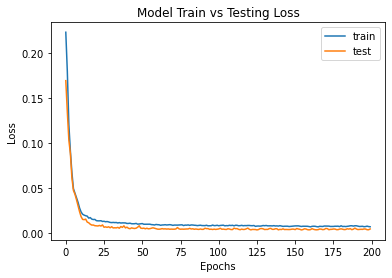

Test RMSE:  147.39372495547428 102.61587390908387 136.36254669308946 0.09011079140474844
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 3, 50)             11400     
                                                                 
 dropout_14 (Dropout)        (None, 3, 50)             0         
                                                                 
 lstm_17 (LSTM)              (None, 20)                5680      
                                                                 
 dropout_15 (Dropout)        (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 4)                 84        
                                                                 
Total params: 17,164
Trainable params: 17,164
Non-trainable params: 0
___________________________

In [16]:
#from numpy import array

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dropout
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

#load dataset
dataset = read_csv('phy_cps.csv', header=0, index_col=0)
values = dataset.values
 
#integer encode wind direction, as it's the only categorical variable.
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
 
#ensure all data are float32 values
values = values.astype('float32')
 
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
 
#frame as supervised learning
n_hours = 3 
n_features = 6 
reframed = series_to_supervised(scaled, n_hours, 1)
values = reframed.values
n_train_hours = 1936
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
 

#split into input and outputs
n_obs = n_hours * n_features
train_X = train[:, :n_obs]
train_y = train[:, -n_features:(-n_features+4)] #+2 because of indexing madness.
test_X = test[:, :n_obs]
test_y = test[:, -n_features:(-n_features+4)]
 
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
 

#Need to output four values, not one.
#design network
model = Sequential()
model.add(LSTM(50, activation='relu',return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))
# model.add(LSTM(20, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
model.add(LSTM(20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(4))

model.compile(loss='mse', optimizer='adam')
 
#fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# Plot history
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.title('Model Train vs Testing Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 

#make a prediction
y_hat = model.predict(test_X)
 

test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
inv_yhat = concatenate((y_hat, test_X[:,-2:]), axis=1) #changed 7 to 6
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0:4] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions
 

#invert scaling for actual
test_y = test_y.reshape((len(test_y),4)) #changed 1 to 2
inv_y = concatenate((test_y, test_X[:,-2:]), axis=1) #changed 7 to 6
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0:4] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions.
 

#calculate RMSE - CHANGED to output RMSE for each variable.
rmse_1 = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0])) #RMSE for the first variable (Tank_1)
rmse_2 = sqrt(mean_squared_error(inv_y[:,1], inv_yhat[:,1])) #RMSE for the second variable (Tank_2)
rmse_3 = sqrt(mean_squared_error(inv_y[:,2], inv_yhat[:,2])) #RMSE for the third variable (Tank_3)
rmse_4 = sqrt(mean_squared_error(inv_y[:,3], inv_yhat[:,3])) #RMSE for the fourth variable (Pump_1)

print('Test RMSE: ', rmse_1, rmse_2, rmse_3, rmse_4)
model.summary()